In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import nltk
from typing import Dict, List, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
from datasets import Dataset, DatasetDict
from tqdm import tqdm
from nltk.corpus import stopwords as nltk_stopwords
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
    set_seed
)
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    f1_score
)

set_seed(27)
tqdm.pandas()
nltk.download('stopwords')
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

2024-03-09 10:17:46.267797: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 10:17:46.267913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 10:17:46.417584: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading data

In [2]:
train_ds = pd.read_csv("/kaggle/input/fake-news/train.csv")
test_ds = pd.read_csv("/kaggle/input/fake-news/test.csv")

# Used later for creating the submission file
test_ds_ids = test_ds['id']

train_ds.shape, test_ds.shape

((20800, 5), (5200, 4))

In [3]:
train_ds.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [4]:
train_ds[train_ds.text.isna()].head(10).T

,142,573,1200,1911,2148,2169,2793,3329,3729,4288
id,142,573,1200,1911,2148,2169,2793,3329,3729,4288
title,Gorafi Magazine : Entretien exclusif avec Bara...,Le top des recherches Google passe en top des ...,La Corée du Nord annonce avoir envoyé un missi...,Grand-Prix du Brésil – Romain Grosjean obtient...,Gorafi Magazine: Barack Obama « Je vous ai déj...,"#NDDL: Pour fêter l’autorisation des travaux, ...",«Pourquoi je suis candidat à la présidentielle...,GuinessBook : 100 millions d’Américains batten...,Les Américains ne sont plus qu’à quelques heur...,Hillary Clinton en 5 dates >> Le Gorafi
author,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
text,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,1,1,1,1,1,1,1,1,1,1


There are quite a few missing values within the `text` and `title` columns. These are the two columns in which the majority of our features are. It's worth pointing out that each data point either has missing `title` or `text`, but not both. To address this issue, I will merge the `text` and `title` columns to create a new column.

In [5]:
def create_new_text(row):
    return "Author(s): " + row["author"] + "\n" + "Title: " + row["title"] + "\n\n" + row["text"]


train_ds["author"] = train_ds["author"].fillna("")
train_ds["title"] = train_ds["title"].fillna("")
train_ds["text"] = train_ds["text"].fillna("")
train_ds["new_text"] = train_ds.apply(create_new_text, axis=1)

test_ds["author"] = test_ds["author"].fillna("")
test_ds["title"] = test_ds["title"].fillna("")
test_ds["text"] = test_ds["text"].fillna("")
test_ds["new_text"] = test_ds.apply(create_new_text, axis=1)

# Visualizing Text Lengths

In [6]:
def get_token_counts(dataset: pd.DataFrame) -> Dict:
    token_counts = {"test": []}
    for _, row in dataset.iterrows():
        token_count = len(row["new_text"].split(" "))
        if "label" in list(dataset.columns):
            if row["label"] not in token_counts:
                token_counts[row["label"]] = [token_count]
            else:
                token_counts[row["label"]].append(token_count)
        else:
            token_counts["test"].append(token_count)
    return token_counts


train_counts = get_token_counts(train_ds.copy())
test_counts = get_token_counts(test_ds.copy())

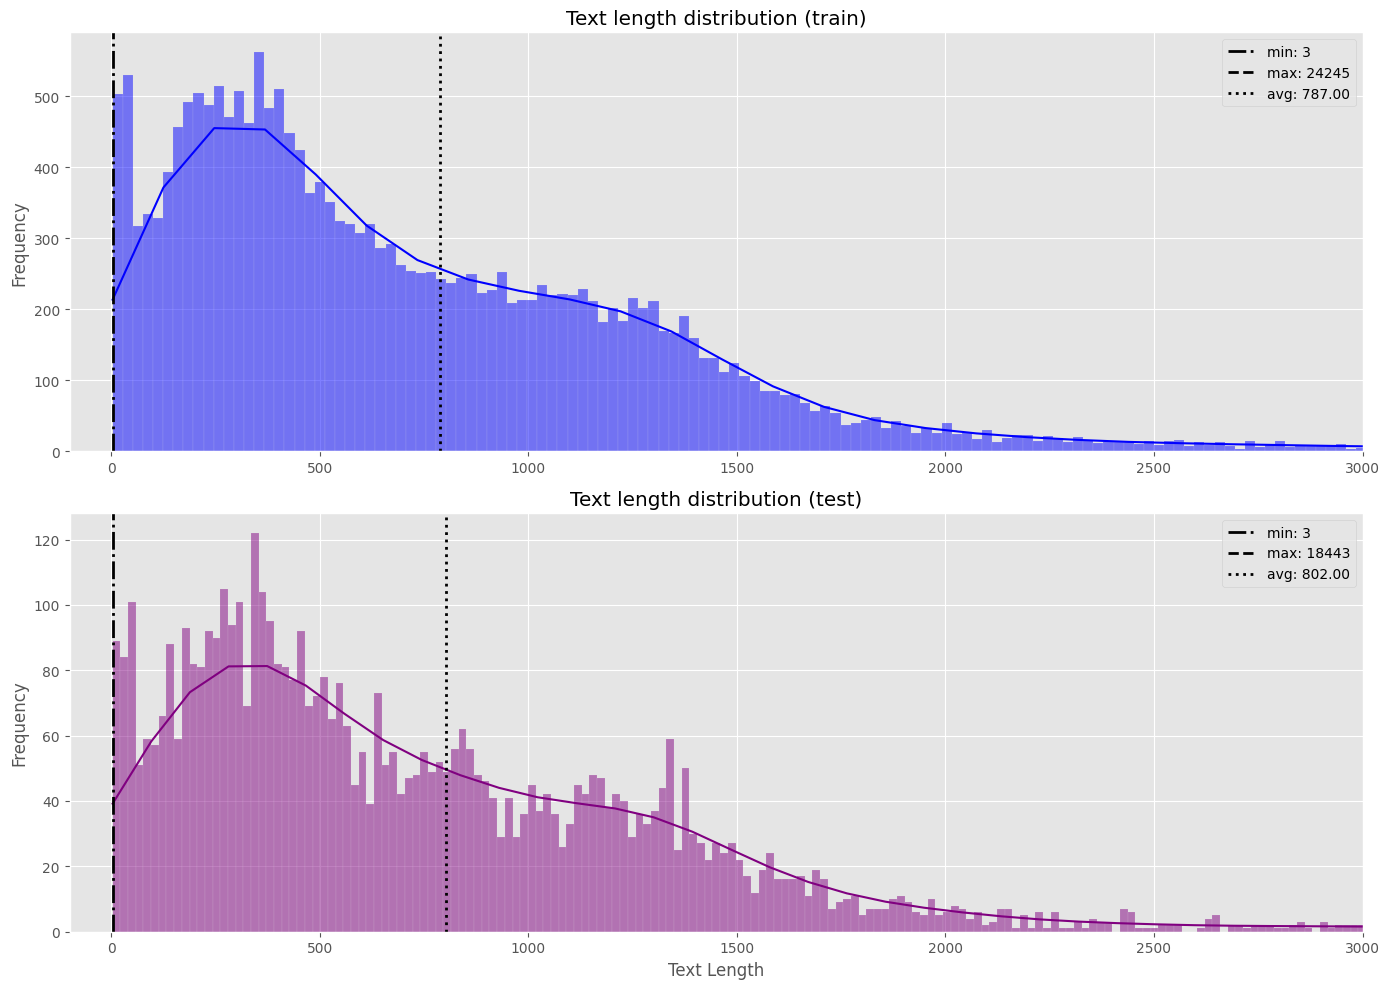

In [7]:
train_avg_length = int((sum(train_counts[0]) + sum(train_counts[1])) / (len(train_counts[1]) + len(train_counts[0])))
train_max_length = max(max(train_counts[0]), max(train_counts[1]))
train_min_length = min(min(train_counts[0]), min(train_counts[1]))

test_avg_length = int(sum(test_counts["test"]) / len(test_counts["test"]))
test_max_length = max(test_counts["test"])
test_min_length = min(test_counts["test"])

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 10))

sns.histplot(train_counts[0] + train_counts[1], kde=True, color="blue", bins=1000, ax=axes[0])
axes[0].axvline(train_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {train_min_length}')
axes[0].axvline(train_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {train_max_length}')
axes[0].axvline(train_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {train_avg_length:.2f}')
axes[0].set_title("Text length distribution (train)")
axes[0].set_ylabel("Frequency")
axes[0].set_xlim(-100, 3000)
axes[0].legend()

sns.histplot(test_counts["test"], kde=True, color="purple", bins=1000, ax=axes[1])
axes[1].axvline(test_min_length, color='black', linestyle='dashdot', linewidth=2, label=f'min: {test_min_length}')
axes[1].axvline(test_max_length, color='black', linestyle='dashed', linewidth=2, label=f'max: {test_max_length}')
axes[1].axvline(test_avg_length, color='black', linestyle='dotted', linewidth=2, label=f'avg: {test_avg_length:.2f}')
axes[1].set_title("Text length distribution (test)")
axes[1].set_xlabel("Text Length")
axes[1].set_ylabel("Frequency")
axes[1].set_xlim(-100, 3000)
axes[1].legend()

plt.tight_layout()
plt.show()

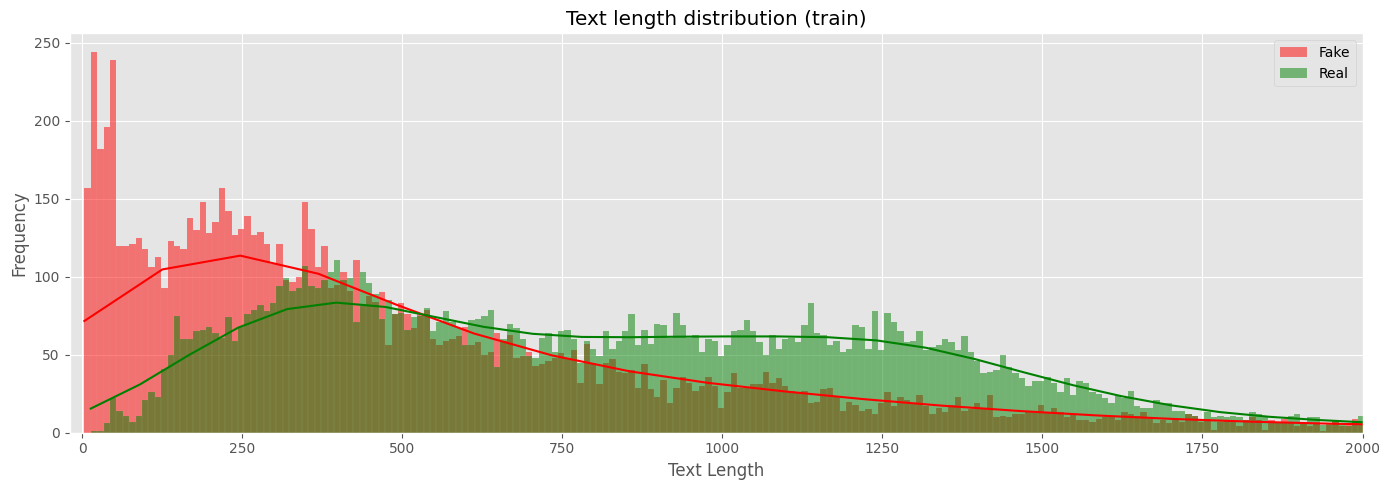

In [8]:
bin_width = 10
bins = range(
    min(min(train_counts[0]), min(train_counts[1])), 
    max(max(train_counts[0]), max(train_counts[1])) + bin_width, 
    bin_width
)

plt.figure(figsize=(14, 5))
sns.histplot(train_counts[1], kde=True, color="red", bins=bins, label="Fake")
sns.histplot(train_counts[0], kde=True, color="green", bins=bins, label="Real")
plt.title("Text length distribution (train)")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.xlim(left=-20, right=2000)
plt.legend()
plt.tight_layout()
plt.show()

# Dimensionality Reduction with PCA, t-SNE, and UMAP

In [9]:
def get_tfidf_vectors(corpus: np.ndarray, stop_words: str, max_features: int, n: int) -> np.ndarray:
    vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features, ngram_range=(n, n))
    vectorized = vectorizer.fit_transform(corpus)
    return vectorized


corpus = train_ds['new_text'].values
labels = train_ds['label'].values
max_features = 300

unigram_vectors_with_stopwords = get_tfidf_vectors(corpus, 'english', max_features, 1)
bigram_vectors_with_stopwords = get_tfidf_vectors(corpus, 'english', max_features, 2)
unigram_vectors_without_stopwords = get_tfidf_vectors(corpus, None, max_features, 1)
bigram_vectors_without_stopwords = get_tfidf_vectors(corpus, None, max_features, 2)

In [10]:
def plot_tfidf_vectors(X: np.ndarray, labels: np.ndarray, title: str) -> None:
    pca = PCA(n_components=2, random_state=27).fit_transform(X.toarray())
    tsne = TSNE(n_components=2, init="random", random_state=27, perplexity=30, n_iter=1000, n_jobs=-1).fit_transform(X)
    umap = UMAP(n_components=2, random_state=27, n_neighbors=5, min_dist=0.8, n_jobs=-1).fit_transform(X.toarray())

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

    axes[0].scatter(pca[:,0], pca[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[0].set_title('PCA', fontsize=10)
    axes[1].scatter(umap[:,0], umap[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[1].set_title('UMAP', fontsize=10)
    axes[2].scatter(tsne[:,0], tsne[:,1], c=labels, alpha=0.05, cmap='coolwarm')
    axes[2].set_title('t-SNE', fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

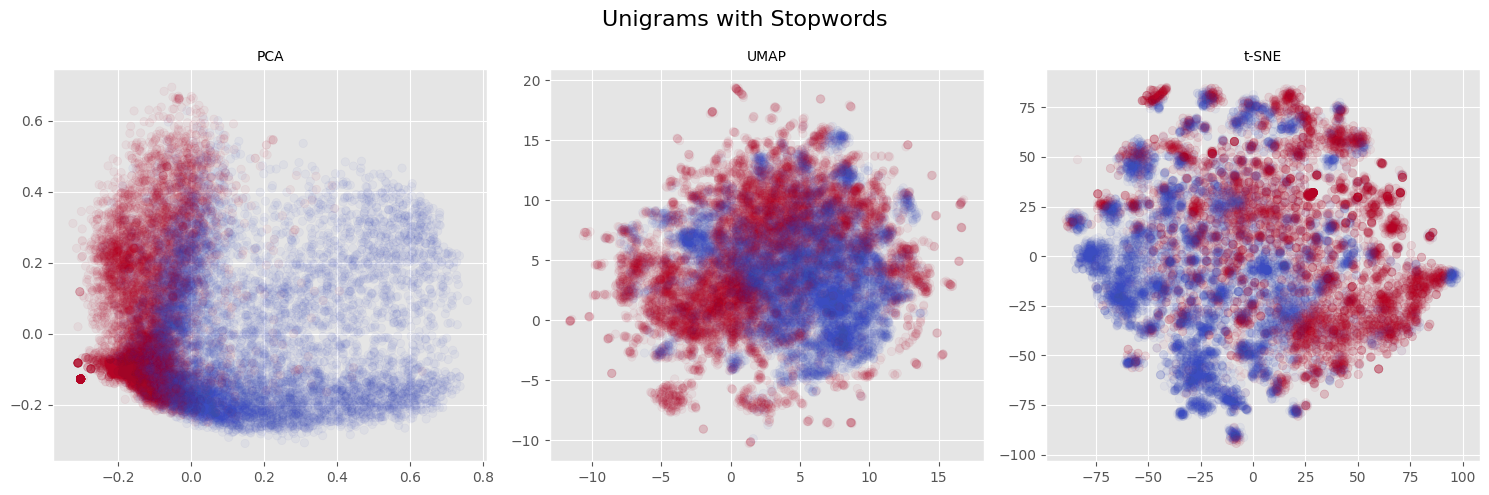

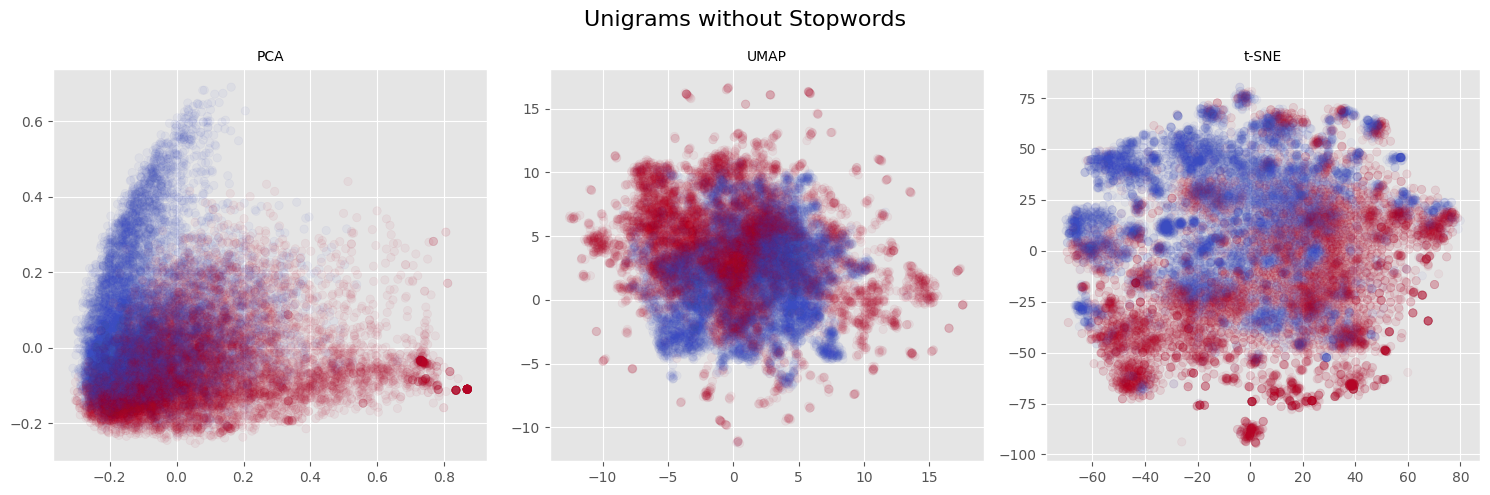

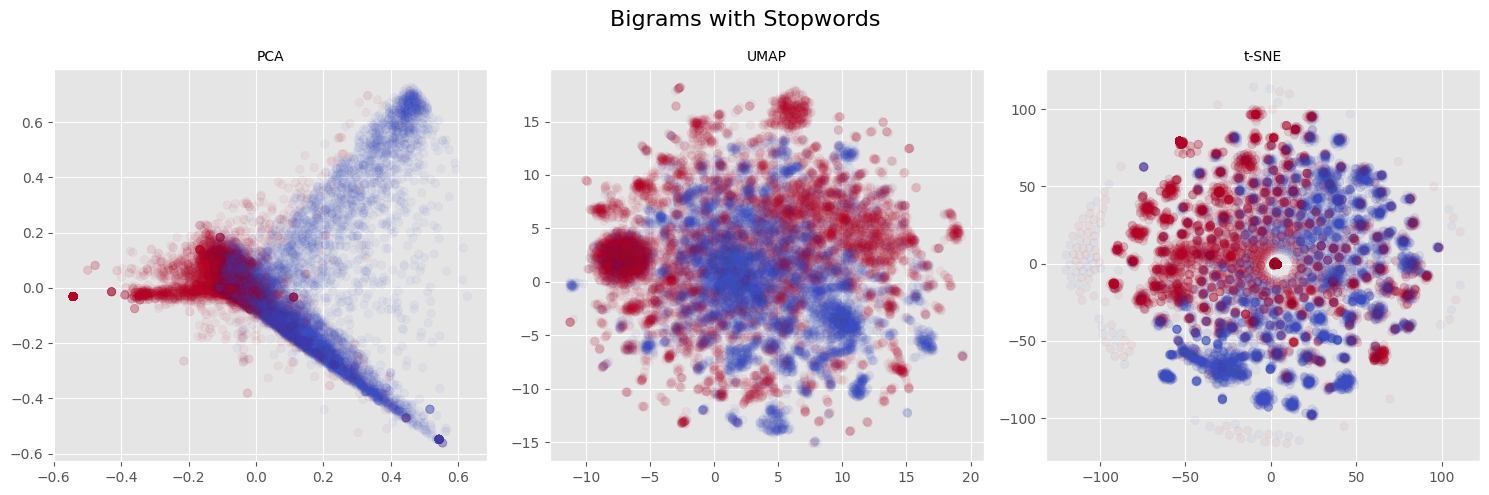

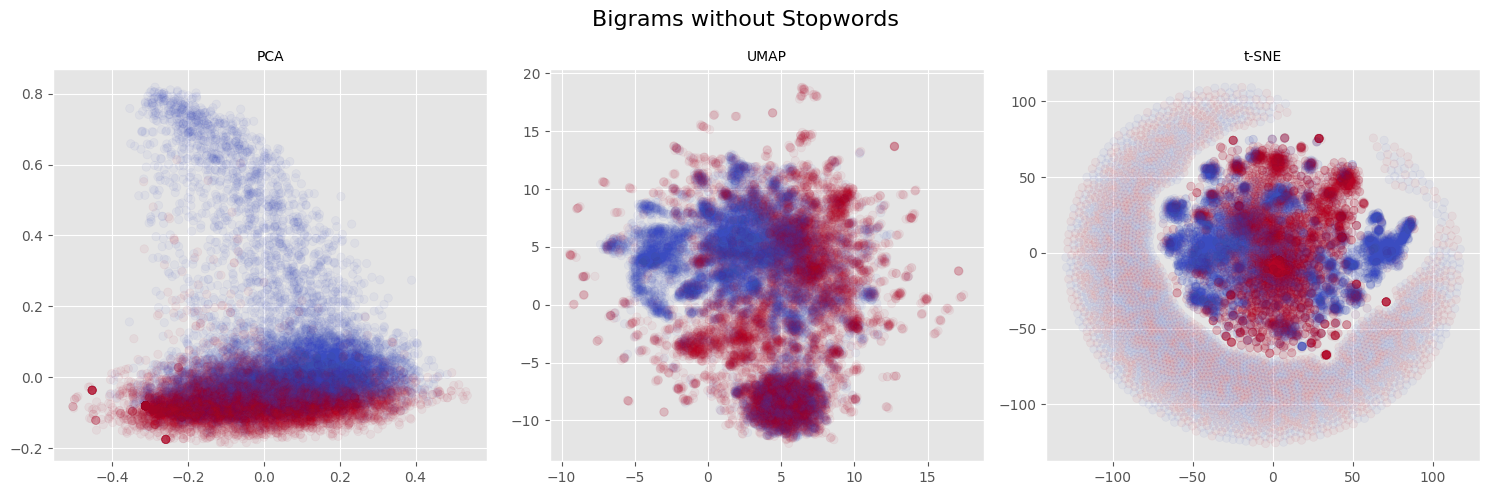

In [11]:
plot_tfidf_vectors(unigram_vectors_with_stopwords, labels, 'Unigrams with Stopwords')
plot_tfidf_vectors(unigram_vectors_without_stopwords, labels, 'Unigrams without Stopwords')
plot_tfidf_vectors(bigram_vectors_with_stopwords, labels, 'Bigrams with Stopwords')
plot_tfidf_vectors(bigram_vectors_without_stopwords, labels, 'Bigrams without Stopwords')

# Visualizing n-grams

In [12]:
class Preprocessor:
    @staticmethod
    def convert_to_lowercase(dataframe: pd.DataFrame) -> pd.DataFrame:
        tqdm.pandas(desc="Converting to lowercase")
        dataframe.loc[:, "new_text"] = dataframe["new_text"].progress_apply(
            lambda x: x.lower()
        )
        return dataframe

    @staticmethod
    def remove_punctuation(dataframe: pd.DataFrame) -> pd.DataFrame:
        def clean(text):
            text = text.replace("\n", " ")
            text = re.sub(r'[^a-z]+', ' ', text)
            text = re.sub(r'\s+', ' ', text)
            return text

        tqdm.pandas(desc="Removing punctuation")
        dataframe.loc[:, "new_text"] = dataframe["new_text"].progress_apply(lambda x: clean(x))
        
        return dataframe

    def remove_stopwords(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        stopwords = nltk_stopwords.words('english')

        tqdm.pandas(desc="Removing stopwords")
        dataframe.loc[:, "new_text"] = dataframe["new_text"].progress_apply(
            lambda x: " ".join(
                [word for word in x.split() if word not in stopwords]
            )
        )
        return dataframe

    def sanitize(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        dataframe = self.convert_to_lowercase(dataframe)
        dataframe = self.remove_punctuation(dataframe)
        dataframe = self.remove_stopwords(dataframe)
        return dataframe[["new_text", "label"]]

In [13]:
def parse_ngrams(corpus: np.ndarray, n_gram: Tuple[int, int]) -> List[Tuple[str, int]]:
    vec = CountVectorizer(ngram_range=n_gram).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in tqdm(vec.vocabulary_.items(), desc=f"Processing {n_gram}-grams")]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq


cleaned_ds = Preprocessor().sanitize(train_ds)
fake_corpus = cleaned_ds[cleaned_ds.label == 1].new_text.values
real_corpus = cleaned_ds[cleaned_ds.label == 0].new_text.values

Removing stopwords: 100%|██████████| 20800/20800 [00:31<00:00, 660.97it/s]


In [14]:
fake_words = parse_ngrams(fake_corpus, (1, 1))
fake_bigrams = parse_ngrams(fake_corpus, (2, 2))
fake_trigrams = parse_ngrams(fake_corpus, (3, 3))

real_words = parse_ngrams(real_corpus, (1, 1))
real_bigrams = parse_ngrams(real_corpus, (2, 2))
real_trigrams = parse_ngrams(real_corpus, (3, 3))

Processing (3, 3)-grams: 100%|██████████| 4578156/4578156 [00:09<00:00, 494019.84it/s]


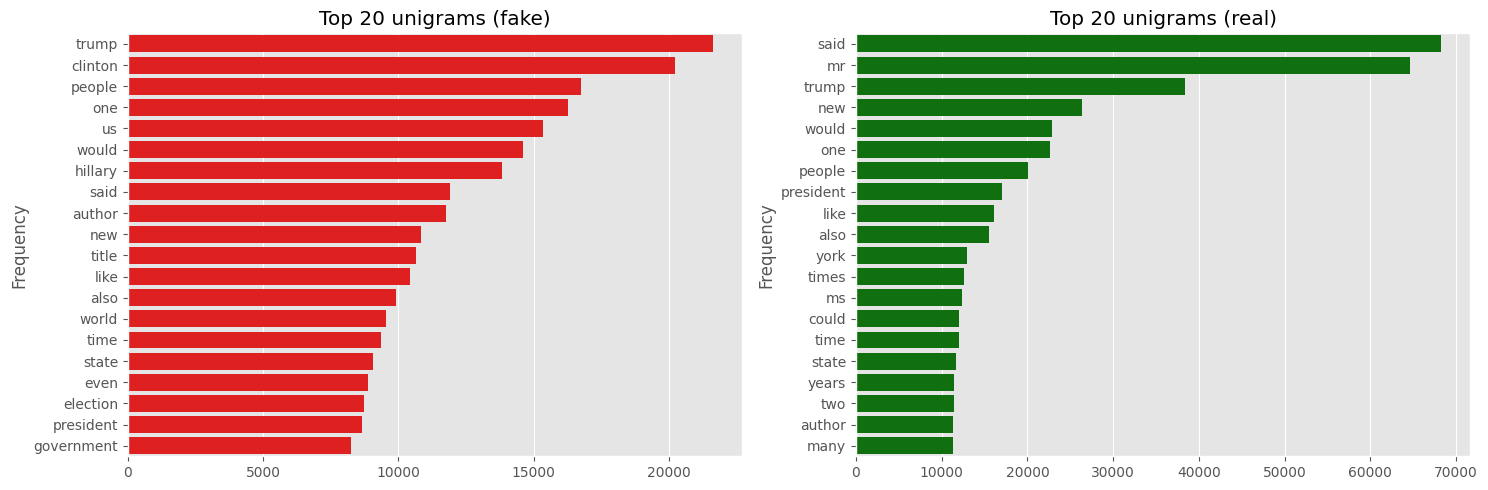

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in fake_words[:20]], x=[item[1] for item in fake_words[:20]], ax=ax[0], color="red")
ax[0].set_title("Top 20 unigrams (fake)")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in real_words[:20]], x=[item[1] for item in real_words[:20]], ax=ax[1], color="green")
ax[1].set_title("Top 20 unigrams (real)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

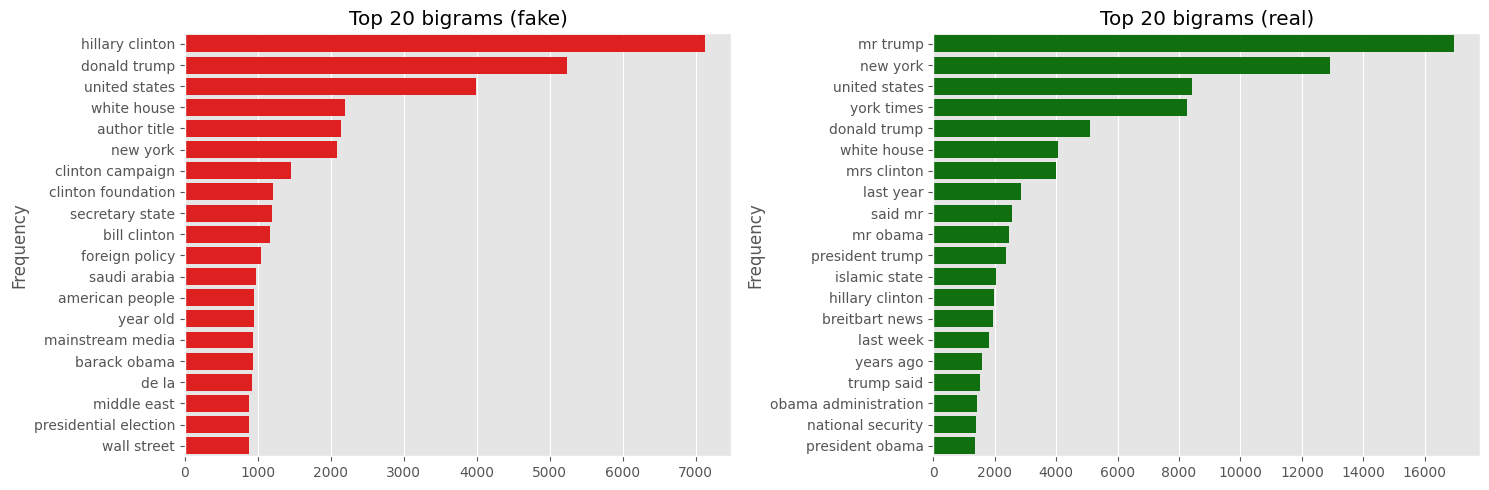

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in fake_bigrams[:20]], x=[item[1] for item in fake_bigrams[:20]], ax=ax[0], color="red")
ax[0].set_title("Top 20 bigrams (fake)")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in real_bigrams[:20]], x=[item[1] for item in real_bigrams[:20]], ax=ax[1], color="green")
ax[1].set_title("Top 20 bigrams (real)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

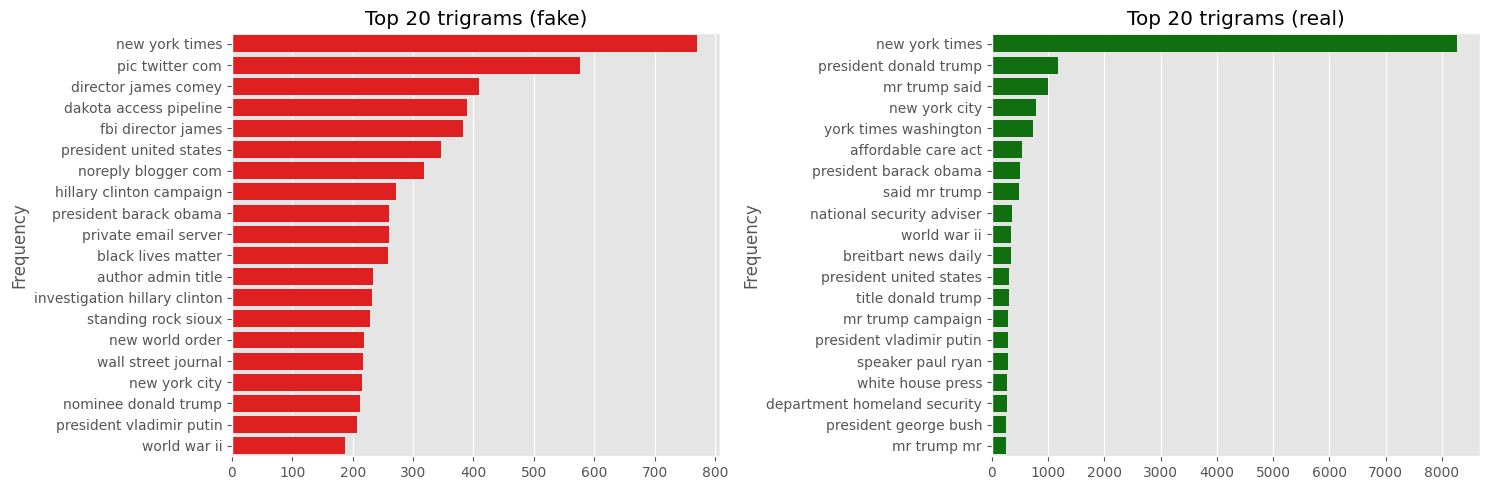

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(y=[item[0] for item in fake_trigrams[:20]], x=[item[1] for item in fake_trigrams[:20]], ax=ax[0], color="red")
ax[0].set_title("Top 20 trigrams (fake)")
ax[0].set_ylabel("Frequency")

sns.barplot(y=[item[0] for item in real_trigrams[:20]], x=[item[1] for item in real_trigrams[:20]], ax=ax[1], color="green")
ax[1].set_title("Top 20 trigrams (real)")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Creating Training Datasets

In [18]:
MODEL_NAME = "roberta-base"
BATCH_SIZE = 16
MAX_TOKEN_LENGTH = 512
EPOCHS = 10
LOG_AND_EVAL_STEPS = 100

In [19]:
train_ds = train_ds[['new_text', 'label']]
test_ds = test_ds[['new_text']]

train_size = int(0.95 * len(train_ds))

train_df = train_ds[:train_size]
val_df = train_ds[train_size:]

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "val": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_ds)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['new_text', 'label'],
        num_rows: 19760
    })
    val: Dataset({
        features: ['new_text', 'label'],
        num_rows: 1040
    })
    test: Dataset({
        features: ['new_text'],
        num_rows: 5200
    })
})

In [20]:
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)


def preprocess_function(examples):
    return tokenizer(
        examples["new_text"],
        truncation=True,
        max_length=MAX_TOKEN_LENGTH,
        padding="max_length"
    )


tokenized_dataset = dataset.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

# Defining Model and Metrics

In [21]:
id2label = {0: "real", 1: "fake"}
label2id = {"real": 0, "fake": 1}

model = RobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    accuracy = accuracy_score(labels, preds)
    auc = roc_auc_score(labels, preds)
    f1 = f1_score(labels, preds)

    return {
        'accuracy': accuracy,
        'auc': auc,
        'f1_score': f1
    }

# Training

In [23]:
training_args = TrainingArguments(
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    output_dir="./logs",
    report_to="none",
    seed=27,
    data_seed=27,
    evaluation_strategy="steps",
    load_best_model_at_end=True,
    eval_steps=LOG_AND_EVAL_STEPS,
    logging_steps=LOG_AND_EVAL_STEPS,
    metric_for_best_model="accuracy"
)

In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["val"],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()
trainer.evaluate()
trainer.save_model("roberta-base-fake-news")

Step,Training Loss,Validation Loss,Accuracy,Auc,F1 Score
100,0.612500,0.461694,0.782692,0.780733,0.815661
200,0.417200,0.370060,0.875962,0.875956,0.877260
300,0.277000,0.259258,0.939423,0.939715,0.938537
400,0.196400,0.234132,0.950000,0.949927,0.950851
500,0.226900,0.213738,0.939423,0.939803,0.938053
600,0.123900,0.195189,0.952885,0.952423,0.955169
700,0.190700,0.159612,0.962500,0.962373,0.963311
800,0.140600,0.130304,0.964423,0.964696,0.963973
900,0.119200,0.346785,0.920192,0.921036,0.914872
1000,0.212900,0.306147,0.894231,0.895348,0.884211


# Plotting Training History

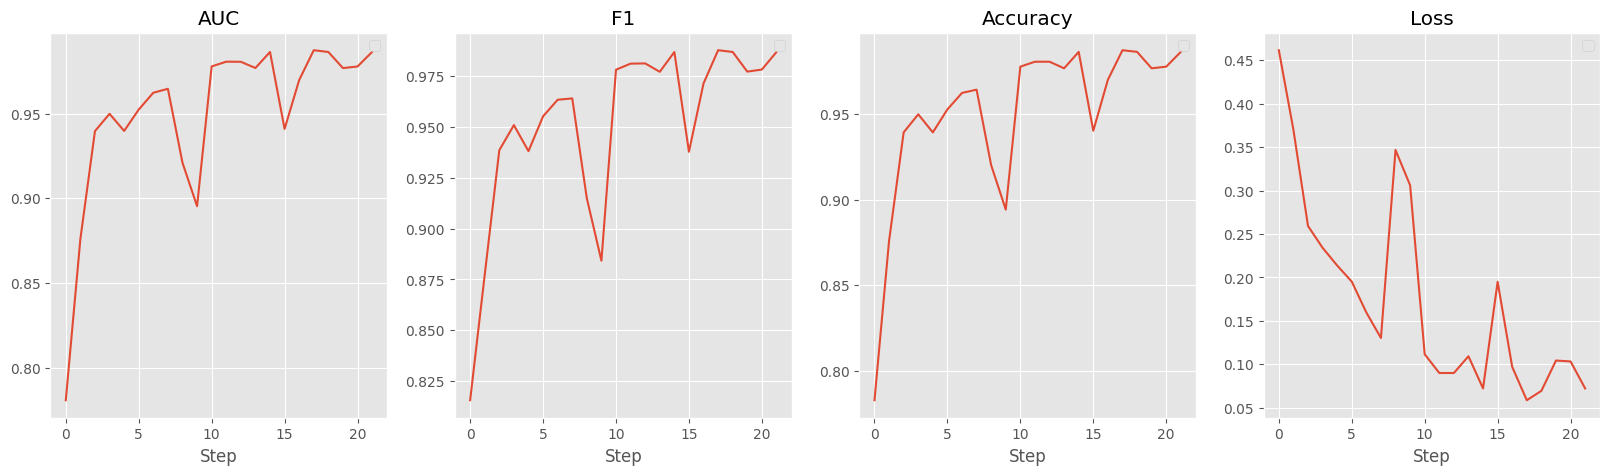

In [25]:
history = pd.DataFrame(trainer.state.log_history).dropna(subset=["eval_loss"]).set_index("step")

histories = {
    "AUC": history['eval_auc'].values,
    "F1": history['eval_f1_score'].values,
    "Accuracy": history['eval_accuracy'].values,
    "Loss": history['eval_loss'].values
}

fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["AUC", "F1", "Accuracy", "Loss"]):
    ax[i].plot(histories[metric])
    ax[i].set_title(metric)
    ax[i].set_xlabel("Step")
    ax[i].legend()

plt.show()                    

# Inferencing

In [26]:
model = RobertaForSequenceClassification.from_pretrained("roberta-base-fake-news")
tokenizer = RobertaTokenizer.from_pretrained("roberta-base-fake-news")

test_texts = test_ds['new_text'].tolist()
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=MAX_TOKEN_LENGTH, return_tensors="pt")
test_dataset = Dataset.from_dict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]})

predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(-1)

# Creating Submission

In [27]:
submission = pd.DataFrame({
    "id": test_ds_ids,
    "label": preds
})
submission.to_csv("submission.csv", index=False)
submission.head()

,id,label
0,20800,1
1,20801,1
2,20802,1
3,20803,1
4,20804,1
